In [29]:
import yfinance as yf
import pandas as pd
from sklearn.metrics import precision_score

In [2]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")

<Axes: xlabel='Date'>

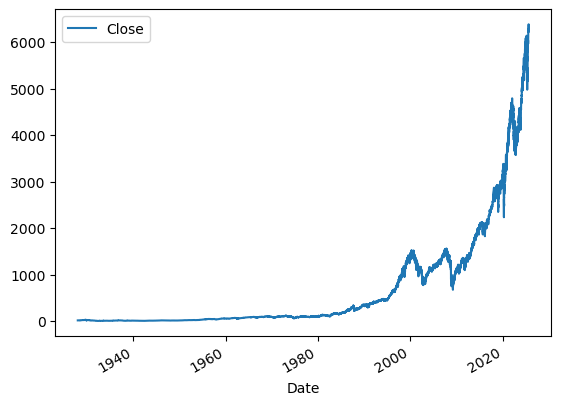

In [4]:
sp500.plot.line(y="Close", use_index=True)

In [5]:
# clear columns
del sp500["Dividends"]
del sp500["Stock Splits"]

In [7]:
# set up target
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int) # is tomorrows price greater than todays?

In [11]:
# remove all data before 1990
sp500 = sp500.loc['1990-01-01':].copy()

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
model = RandomForestClassifier(
    n_estimators = 200, # individual decision trees
    min_samples_split=50, # prevent overfit - higher the worst for accuracy
    random_state = 37
)

In [34]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.6153846153846154

In [25]:
predictors = ["Close", "Volume", "Open", "High", "Low"]

In [66]:
# backtesting
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1 # setting a higher threshold makes predictions more confident
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [44]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [67]:
predictions = backtest(sp500, model, new_predictors)

In [68]:
predictions["Predictions"].value_counts()

Predictions
0.0    4638
1.0     823
Name: count, dtype: int64

In [69]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5613608748481167

In [70]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.546237
0    0.453763
Name: count, dtype: float64

In [57]:
horizons = [2,5,60,250,1000]
new_predictors = []

In [60]:
for h in horizons:
    rolling_averages = sp500.rolling(h).mean()
    sp500[f"CloseRatio_{h}"] = sp500["Close"] / rolling_averages["Close"]
    sp500[f"Trend_{h}"] = sp500.shift(1).rolling(h).sum()["Target"]

    new_predictors += [f"CloseRatio_{h}", f"Trend_{h}"]

In [64]:
sp500 = sp500.dropna()